In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

In [98]:
def confusion_matrix(actual, pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(actual)):
        if actual[i] == 1:
            if pred[i] == 1:
                tp += 1
            else:
                fn += 1
        else:
            if pred[i] ==1:
                fp += 1
            else:
                tn += 1

    return [[tp, fn],[ fp, tn]]


In [99]:
def train_test_split(df, target, test_size=0.2, random_state=41):
    trainX = df.sample(frac=test_size, random_state=random_state)
    testX = df.drop(trainX.index)
    trainY = target.sample(frac=test_size, random_state=random_state)
    testY = target.drop(trainY.index)
    return trainX, testX, trainY, testY


In [100]:
class Node():
    def __init__(self, feature_index: float = None, threshold=None, left=None, right=None, info_gain=None, value=None):

        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value


In [101]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=0, max_depth=0):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:

            best_split = self.get_best_split(
                dataset, num_samples, num_features)

            if best_split["info_gain"] > 0:

                left_subtree = self.build_tree(
                    best_split["dataset_left"], curr_depth+1)

                right_subtree = self.build_tree(
                    best_split["dataset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)

        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float("inf")

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:

                dataset_left, dataset_right = self.split(
                    dataset, feature_index, threshold)

                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -
                                                 1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y)

                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):

        dataset_left = np.array(
            [row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array(
            [row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, mode="entropy"):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == "gini":
            gain = self.gini_index(
                parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(
                parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain

    def entropy(self, y):

        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=",
                  tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):

        print(X.shape)
        print(Y.shape)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, tree):

        if tree.value != None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    def score(self, X, Y):

        print(X.shape)
        print(Y.shape)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)


In [102]:
df = pd.read_csv('data-ques-3\dataset.csv')
df.head()


,size,weight,skincolor,target
0,35,0.571539,139,0
1,23,5.348117,184,0
2,38,3.419377,126,0
3,34,3.323665,137,0
4,34,1.453573,198,0


In [103]:
target = df['target']
df1 = df.copy()
df1 = df1.drop('target', axis=1)


In [104]:
# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(
    df1, target, test_size=0.2, random_state=41)
print("Training split input- ", X_train.shape)
print("Training split input- ", y_train.shape)
print("Testing split input- ", X_test.shape)
print("Testing split input- ", y_test.shape)
print(X_train.head())
print(y_train.head())


Training split input-  (40, 3)
Training split input-  (40,)
Testing split input-  (160, 3)
Testing split input-  (160,)
     size    weight  skincolor
96     24  2.324527        202
63     17  5.832351        159
168    18  0.616260        287
196    21  0.543074        160
68     22  5.488565        181
96     0
63     0
168    1
196    1
68     0
Name: target, dtype: int64


In [105]:
# Defining the decision tree algorithm
dtree = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
dtree.fit(X_train.values, y_train.values.reshape(-1, 1))
print('Decision Tree Classifier Created')


(40, 3)
(40, 1)
Decision Tree Classifier Created


In [106]:
# Predicting the values of test data
y_pred = dtree.predict(X_test.values)
print("Classification report - \n",
      classification_report(y_test.values.reshape(-1, 1), y_pred))


Classification report - 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90        80
           1       0.93      0.86      0.90        80

    accuracy                           0.90       160
   macro avg       0.90      0.90      0.90       160
weighted avg       0.90      0.90      0.90       160



[[69, 11], [5, 75]]


Text(24.0, 0.5, 'Actual label')

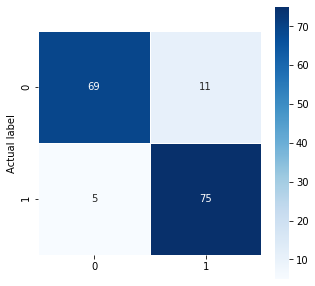

In [107]:
cm = confusion_matrix(y_test.values.reshape(-1, 1), y_pred)
print(cm)
plt.figure(figsize=(5, 5))
sns.heatmap(data=cm, linewidths=.5, annot=True, square=True,  cmap='Blues')
plt.ylabel('Actual label')
#all_sample_title = 'Accuracy Score: {0}'.format(dtree.score(X_test, y_test))
#plt.title(all_sample_title, size = 15)


In [108]:
# Visualising the graph without the use of graphvizplt.figure(figsize = (20,20))
dtree.print_tree()


X_1 <= 0.79519665 ? 0.7582766571931676
 left:X_0 <= 25.0 ? 0.4394969869215134
  left:1.0
  right:0.0
 right:0.0
